<a href="https://colab.research.google.com/github/adityanarayan-rai/flood_detection_ban/blob/main/01_flood_jamalpur_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# -------------------------------
# Install & Import Dependencies
# -------------------------------

!pip install sentinelhub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.5 MB/s eta 0:00:00


In [109]:
# -------------------------------------
# Import libraries
# -------------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np
import joblib
from contextlib import contextmanager
from tqdm import tqdm
import matplotlib.pyplot as plt
from sentinelhub import SHConfig, BBox, CRS, SentinelHubRequest, MimeType, DataCollection, bbox_to_dimensions
from sklearn.model_selection import train_test_split, GridSearchCV, train_test_split, KFold

In [10]:
# -------------------------------------
# Perepare data
# -------------------------------------

# Configure Sentinel Hub Access

# Setup config
config = SHConfig()
# Uncomment and set these if not stored in config file
config.sh_client_id = "e3cc4ef5-1042-430a-9fbd-1ca499134e54"
config.sh_client_secret = "IHkGxCm3EZwVaeUiOrVzJOKTggL04Yp6"

In [11]:
# Define Area of Interest (Jamalpur)

jamalpur_bbox_coords = [89.85, 25.00, 89.98, 25.12]
resolution = 20

bbox = BBox(bbox=jamalpur_bbox_coords, crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

In [12]:
# Download Sentinel-1 SAR Imagery (VV band)
# Used to detect flooding based on backscatter change

sar_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["VV"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  return [sample.VV];
}
"""

# Pre-flood
sar_pre_request = SentinelHubRequest(
    evalscript=sar_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL1,
        time_interval=('2020-06-15', '2020-06-25'),
        mosaicking_order='mostRecent'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
sar_pre_image = sar_pre_request.get_data()[0]

# Post-flood
sar_post_request = SentinelHubRequest(
    evalscript=sar_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL1,
        time_interval=('2020-08-01', '2020-08-10'),
        mosaicking_order='mostRecent'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
sar_post_image = sar_post_request.get_data()[0]

In [13]:
# Download Sentinel-2 NDVI
# Used to estimate vegetation loss (crop damage)
# NDVI = (NIR - Red) / (NIR + Red)

ndvi_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B08", "B04"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  return [ndvi];
}
"""

ndvi_request = SentinelHubRequest(
    evalscript=ndvi_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL2_L2A,
        time_interval=('2020-08-01', '2020-08-10'),
        mosaicking_order='leastCC'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
ndvi_image = ndvi_request.get_data()[0]


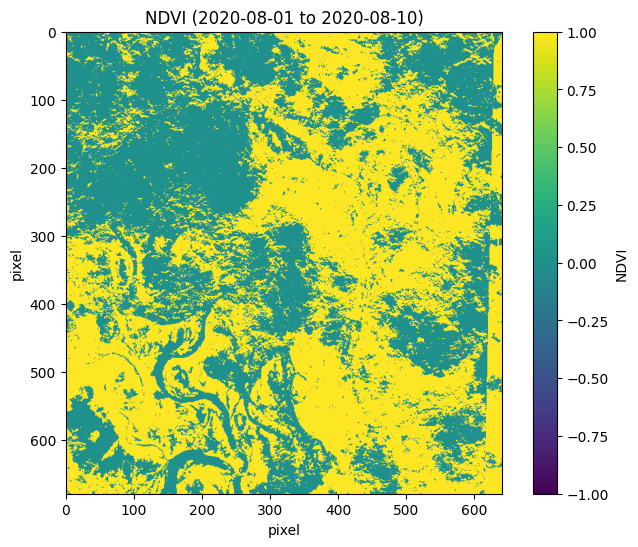

In [14]:
import matplotlib.pyplot as plt

# ndvi_image comes back as a 2D or 3D array: squeeze out any singleton dim
ndvi = ndvi_image.squeeze()

plt.figure(figsize=(8, 6))
# NDVI typically runs from –1 to +1
plt.imshow(ndvi, vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI (2020-08-01 to 2020-08-10)')
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.show()

In [86]:
# Compute NDWI from Sentinel-2
# Used to detect surface water (floods)
# NDWI = (Green - NIR) / (Green + NIR)

ndwi_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B03", "B08"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  var ndwi = (sample.B03 - sample.B08) / (sample.B03 + sample.B08);
  return [ndwi];
}
"""

ndwi_request = SentinelHubRequest(
    evalscript=ndwi_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL2_L2A,
        time_interval=('2020-08-01', '2020-08-10'),
        mosaicking_order='leastCC'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
ndwi_image = ndwi_request.get_data()[0]


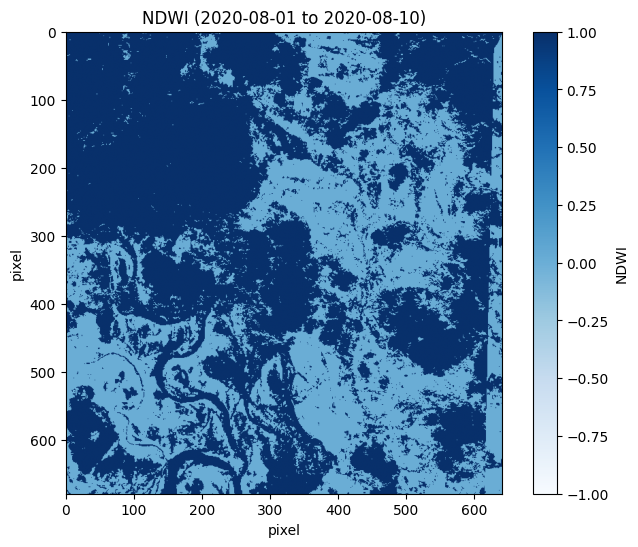

In [87]:
# Visualize NDWI Map

ndwi = ndwi_image.squeeze()

plt.figure(figsize=(8, 6))
plt.imshow(ndwi, vmin=-1, vmax=1, cmap='Blues')
plt.colorbar(label='NDWI')
plt.title('NDWI (2020-08-01 to 2020-08-10)')
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.show()

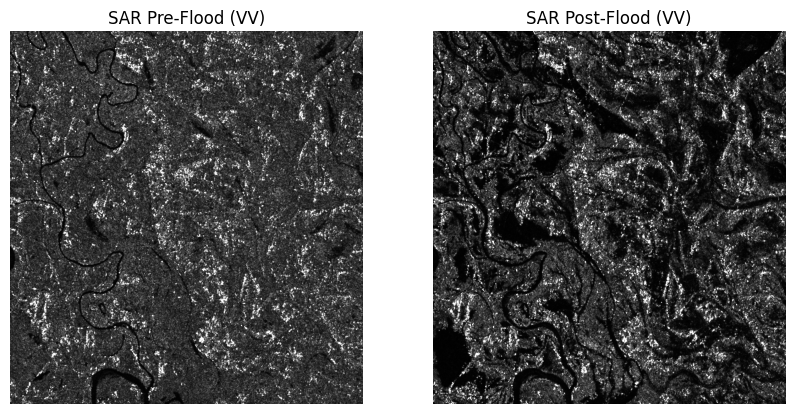

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('SAR Pre-Flood (VV)')
plt.imshow(sar_pre_image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('SAR Post-Flood (VV)')
plt.imshow(sar_post_image.squeeze(), cmap='gray')
plt.axis('off')

plt.show()


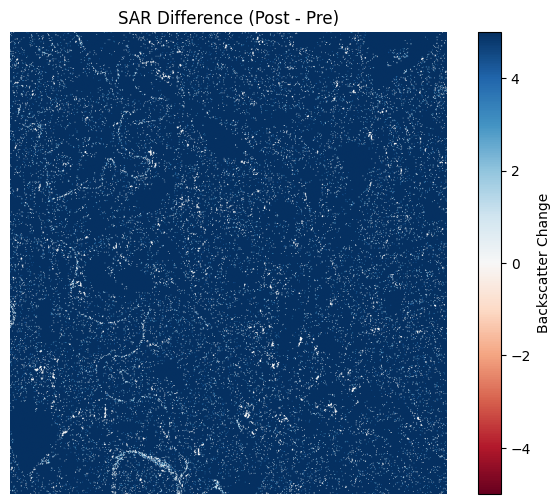

In [89]:
import numpy as np

# Compute SAR difference
sar_diff = sar_post_image.squeeze() - sar_pre_image.squeeze()

plt.figure(figsize=(8, 6))
plt.imshow(sar_diff, cmap='RdBu', vmin=-5, vmax=5)
plt.title('SAR Difference (Post - Pre)')
plt.colorbar(label='Backscatter Change')
plt.axis('off')
plt.show()

Generate Binary Flood Mask from NDWI
This mask will serve as pseudo-ground-truth for classification.

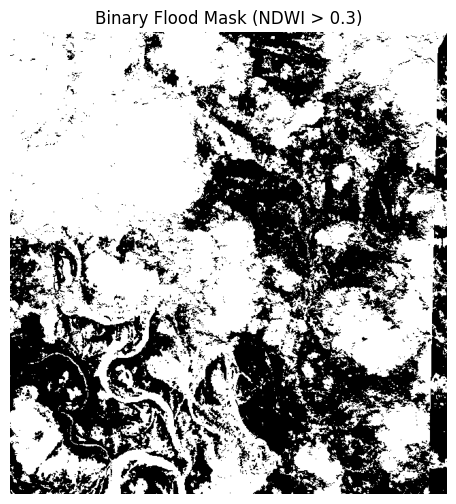

In [90]:
# Threshold NDWI to detect water (e.g., NDWI > 0.3)
flood_mask = (ndwi > 0.3).astype(int)

plt.figure(figsize=(6, 6))
plt.imshow(flood_mask, cmap='gray')
plt.title('Binary Flood Mask (NDWI > 0.3)')
plt.axis('off')
plt.show()


Create Feature Matrix for Classification
Stack SAR diff, NDWI, and NDVI as input features.

In [93]:
# Flatten arrays and stack features
# Use only SAR difference to predict damage classes (avoids leakage from NDVI/NDWI)
X = sar_diff.ravel().reshape(-1, 1)

y = flood_mask.ravel()

# Remove invalid pixels (NaNs)
valid_mask = ~np.isnan(X).any(axis=1)
X_clean = X[valid_mask]
y_clean = y[valid_mask]

In [94]:
# Show class balance in the labels
unique, counts = np.unique(y_clean, return_counts=True)
print("Training label distribution:", dict(zip(unique, counts)))

Training label distribution: {np.int64(0): np.int64(174379), np.int64(1): np.int64(261539)}


# Predictions

Train a Random Forest Classifier
This classifies pixels as flooded or not based on input features.

In [95]:
# -------------------------------------
# Split data and train classifier
# -------------------------------------

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

# Train RF model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [96]:
# -------------------------------------
# Evaluate model performance
# -------------------------------------
y_pred = rf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Show which classes were predicted
unique_preds, pred_counts = np.unique(y_pred, return_counts=True)
print("\nPrediction class distribution:", dict(zip(unique_preds, pred_counts)))

# Accuracy metric
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.01      0.03     52133
           1       0.60      0.99      0.75     78643

    accuracy                           0.60    130776
   macro avg       0.54      0.50      0.39    130776
weighted avg       0.55      0.60      0.46    130776


Prediction class distribution: {np.int64(0): np.int64(1482), np.int64(1): np.int64(129294)}

Accuracy: 0.60


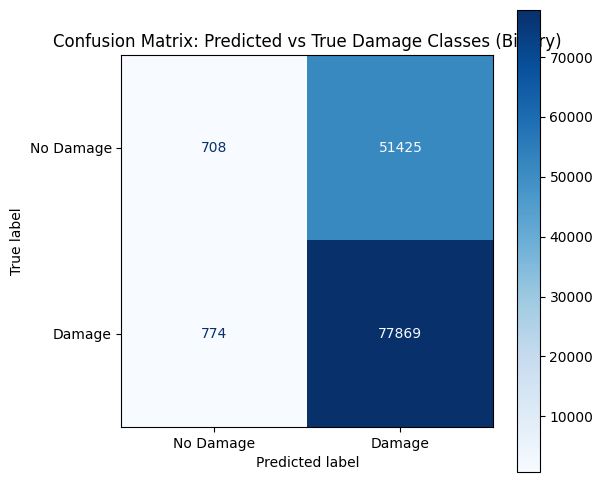

In [97]:
# -------------------------------------
# Visualize confusion matrix
# -------------------------------------

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Damage", "Damage"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format='d')
plt.title("Confusion Matrix: Predicted vs True Damage Classes (Binary)")
plt.show()

### Vegetation damage prediction

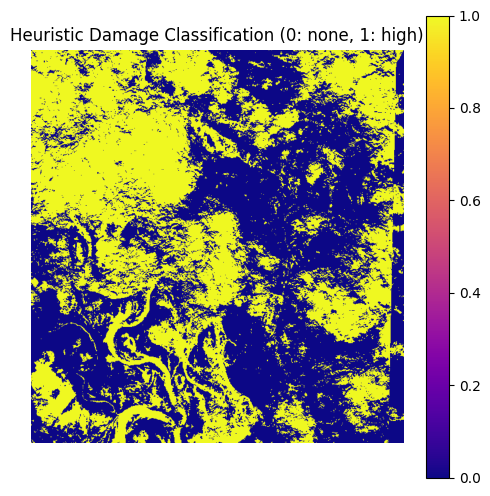

In [98]:
# -------------------------------------
# Define Heuristic Damage Labels (Binary: High vs No Damage)
# -------------------------------------
# NDWI (flood) + NDVI (vegetation loss) => Damage class
# Class 0 = no damage, Class 1 = flooded with NDVI loss (high damage)

damage_mask = np.zeros_like(ndvi, dtype=np.uint8)
damage_mask[(ndwi > 0.3) & (ndvi < 0.3)] = 1  # high damage where water + NDVI drop

plt.figure(figsize=(6, 6))
plt.imshow(damage_mask, cmap='plasma')
plt.title('Heuristic Damage Classification (0: none, 1: high)')
plt.colorbar()
plt.axis('off')
plt.show()


In [99]:
# -------------------------------------
# Prepare Data for Binary Damage Classification (High vs No)
# -------------------------------------
X = sar_diff.ravel().reshape(-1, 1)  # Feature: SAR backscatter difference
y = damage_mask.ravel()             # Label: heuristic damage mask

# Remove invalid pixels
mask = ~np.isnan(X).any(axis=1) & ~np.isinf(X).any(axis=1)
X_clean = X[mask]
y_clean = y[mask]

# Display label balance
import numpy as np
unique, counts = np.unique(y_clean, return_counts=True)
print("Training label distribution:", dict(zip(unique, counts)))

Training label distribution: {np.uint8(0): np.int64(233083), np.uint8(1): np.int64(202835)}



Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64     69884
           1       0.50      0.24      0.33     60892

    accuracy                           0.53    130776
   macro avg       0.52      0.52      0.49    130776
weighted avg       0.52      0.53      0.50    130776



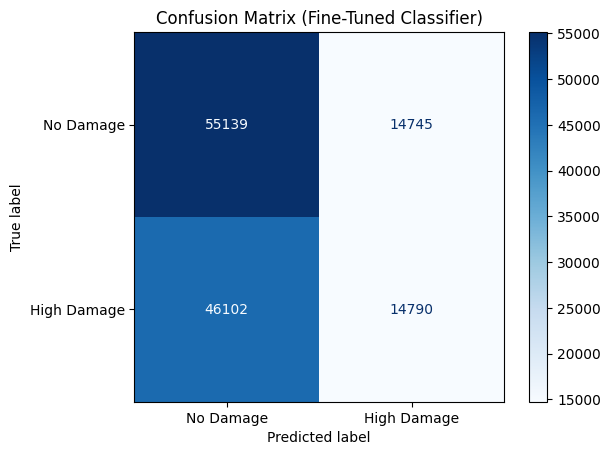

In [100]:
# -------------------------------------
# Train Binary Classifier for Vegetation Damage
# -------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate on test set
y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Damage", "High Damage"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Fine-Tuned Classifier)")
plt.show()

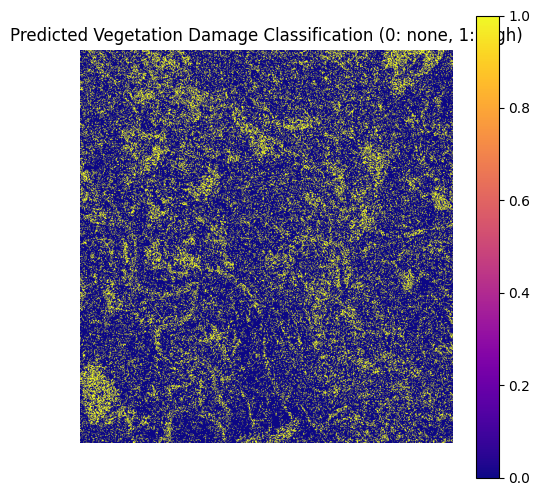

In [102]:
# -------------------------------------
# Predict Damage on Full Image
# -------------------------------------
y_pred_full = clf.predict(X_clean)

damage_prediction = np.zeros_like(y, dtype=np.uint8)
damage_prediction[mask] = y_pred_full
damage_prediction = damage_prediction.reshape(damage_mask.shape)

plt.figure(figsize=(6, 6))
plt.imshow(damage_prediction, cmap='plasma')
plt.title('Predicted Vegetation Damage Classification (0: none, 1: high)')
plt.colorbar()
plt.axis('off')
plt.show()

### Fine Tunning

In [110]:
# -------------------------------------
# Helper: tqdm with joblib
# -------------------------------------
@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=1)
            return super().__call__(*args, **kwargs)

    old_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_callback
        tqdm_object.close()

🔍 Grid search (Random Forest): 100%|██████████| 48/48 [08:45<00:00, 10.95s/it]



🟢 Best hyper‑parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.47      0.51     69884
           1       0.49      0.59      0.53     60892

    accuracy                           0.52    130776
   macro avg       0.53      0.53      0.52    130776
weighted avg       0.53      0.52      0.52    130776



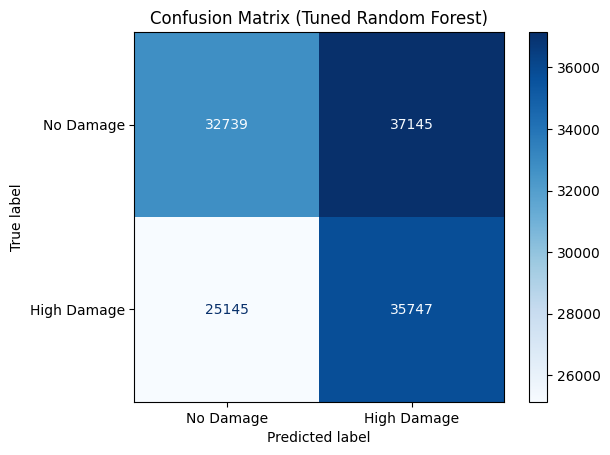

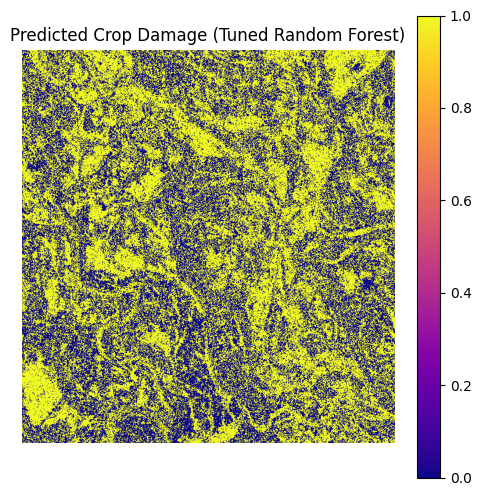

In [111]:
# -------------------------------------
# Grid Search for Random Forest
# -------------------------------------
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10],
    "min_samples_leaf": [3, 5],
    "max_features": ["sqrt", "log2"],
    "class_weight": ["balanced"]
}

n_param_comb = np.prod([len(v) for v in param_grid.values()])
n_cv = 3
total_fits = n_param_comb * n_cv

rf = RandomForestClassifier(random_state=42, n_jobs=1)
cv = KFold(n_splits=n_cv, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0,
    error_score="raise"
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

with tqdm_joblib(tqdm(total=total_fits, desc="🔍 Grid search (Random Forest)")):
    grid.fit(X_train, y_train)

# Best estimator and evaluation
clf = grid.best_estimator_
print("\n🟢 Best hyper‑parameters:", grid.best_params_)

# Evaluate on test set
y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Damage", "High Damage"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Tuned Random Forest)")
plt.show()

# Predict full image
y_pred_full = clf.predict(X_clean)
damage_prediction = np.zeros_like(y, dtype=np.uint8)
damage_prediction[mask] = y_pred_full
damage_prediction = damage_prediction.reshape(damage_mask.shape)

# Visualize
plt.figure(figsize=(6, 6))
plt.imshow(damage_prediction, cmap='plasma')
plt.title('Predicted Crop Damage (Tuned Random Forest)')
plt.colorbar()
plt.axis('off')
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.47      0.51     69884
           1       0.49      0.59      0.53     60892

    accuracy                           0.52    130776
   macro avg       0.53      0.53      0.52    130776
weighted avg       0.53      0.52      0.52    130776



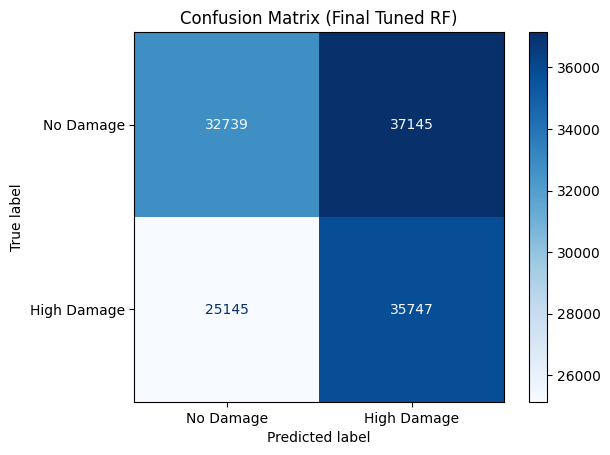

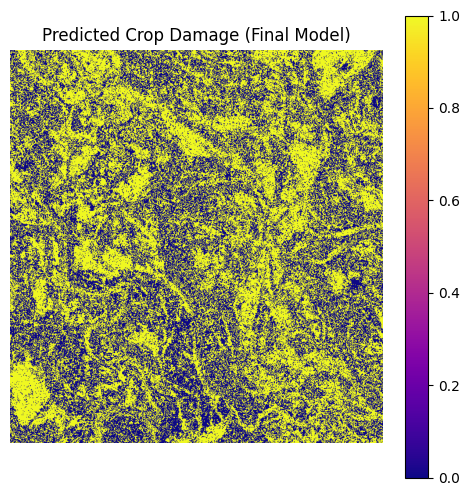

In [112]:
# -------------------------------------
# Final Model (Best Random Forest Parameters)
# -------------------------------------

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

# Use best parameters found earlier
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    max_features="sqrt",
    min_samples_leaf=3,
    class_weight="balanced",
    random_state=42
)
clf.fit(X_train, y_train)

# Evaluate on test set
y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Damage", "High Damage"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Final Tuned RF)")
plt.show()

# Predict full image
y_pred_full = clf.predict(X_clean)
damage_prediction = np.zeros_like(y, dtype=np.uint8)
damage_prediction[mask] = y_pred_full
damage_prediction = damage_prediction.reshape(damage_mask.shape)

# Visualize final prediction
plt.figure(figsize=(6, 6))
plt.imshow(damage_prediction, cmap='plasma')
plt.title('Predicted Crop Damage (Final Model)')
plt.colorbar()
plt.axis('off')
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.47      0.51     69884
           1       0.49      0.59      0.53     60892

    accuracy                           0.52    130776
   macro avg       0.53      0.53      0.52    130776
weighted avg       0.53      0.52      0.52    130776



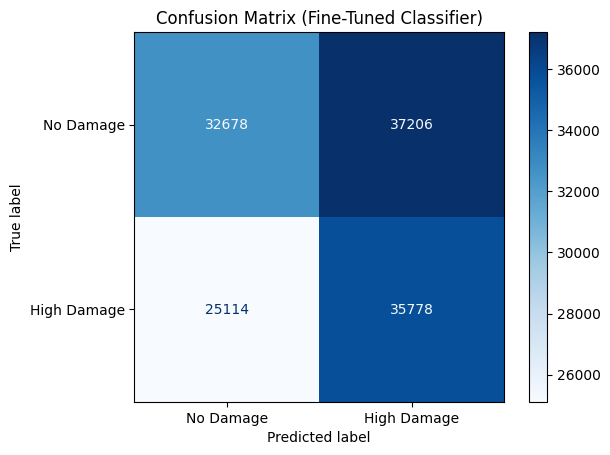

In [84]:
# Evaluate on test set
y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Damage", "High Damage"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Tuned Random Forest)")
plt.show()

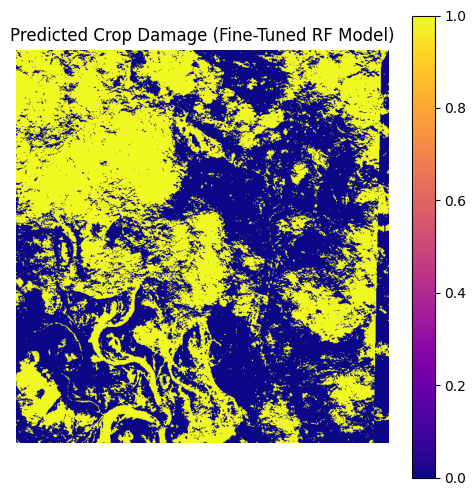

In [79]:
# -------------------------------------
# Predict Full Damage Map
# -------------------------------------
y_pred_full = clf.predict(X_clean)

damage_prediction = np.zeros_like(y, dtype=np.uint8)
damage_prediction[valid_mask] = y_pred_full
damage_prediction = damage_prediction.reshape(damage_mask.shape)

# Visualize Final Output
plt.figure(figsize=(6, 6))
plt.imshow(damage_prediction, cmap='plasma')
plt.title('Predicted Crop Damage (Fine-Tuned RF Model)')
plt.colorbar()
plt.axis('off')
plt.show()